In [1]:
#Coded by Brieuc Guinard

import numpy as np
import random
import operator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from fractions import gcd
import matplotlib.colors as colors

import pickle

import datetime
import time

#from shapely.geometry import LineString
#from shapely.geometry import Point

In [3]:
###LOAD RESULTS OF PREVIOUS COMPUTATIONS
#if it's the first time using this, initialize: TimesLevyProbaDetect=dict()

In [2]:
filehandler=open('HittingTimeLevyDifferentSizeTargetShapeCutOffProbaDetect.obj','r')
TimesLevyProbaDetect=pickle.load(filehandler)
filehandler.close()

In [3]:
### MODEL FUNCTIONS

In [1]:
##LÉVY DISTRIBUTION with exponent mu and cut-off lmax 

rangemu_LevyDistrib=[round(1+0.1*i,2) for i in range(21)]
l_medium=150
range_lmax=[112,150,
 187,
 262,
 375,
 525,
 750,
 900,
 1050,
 1200]

#rangen=[(100*i)**2 for i in range(1,11)]; rangen.append(30*30)
a=dict()
ExpectedLength=dict()
for lmax in range_lmax:
    for mu in rangemu_LevyDistrib:
        s=0
        for l in range(1,lmax):
            s+=1.0/(l**mu);
        a[(mu,lmax)]=s**(-1)  #########BEWARE NOW IT IS a[lmax,mu] and NOT a[n,mu]
    for mu in rangemu_LevyDistrib:
        s=0
        for l in range_lmax:
            s+=a[(mu,lmax)]*l/(l**mu);
        ExpectedLength[(mu,lmax)]=s
        
def Levy(mu,lmax):
    x=random.uniform(0,1);
    s=0; l=0;
    while s<x:
        l+=1
        s+=a[(mu,lmax)]/float(l**mu)
    return l

In [4]:
#Intermittent Levy search (detection only in-between steps)

def LevySearch(n,mu,lmax,D,TargetShape):
    time=0
    sqrt_n=np.sqrt(n)
    walker=np.array((np.random.uniform(0,sqrt_n),np.random.uniform(0,sqrt_n)))
    center=np.array((sqrt_n*0.5,sqrt_n*0.5)) #Note that the distance from the center in the torus
    #is given by the same formula that in R^2
    
    found=False
    if TargetShape=='Ball':
        while not found:
            l=Levy(mu,lmax)
            theta=random.uniform(0,2*np.pi)
            direction=np.array((np.cos(theta),np.sin(theta)))
         
            walker_old=walker.copy()
            walker+=direction*l
            walker%=sqrt_n

            time+=l

            if np.sqrt((walker[0]-center[0])**2+(walker[1]-center[1])**2)<=0.5*D+1:
                found=True;
    if TargetShape=='Line':
        while not found:
            l=Levy(mu,lmax)
            theta=random.uniform(0,2*np.pi)
            direction=np.array((np.cos(theta),np.sin(theta)))
            walker+=direction*l
            walker%=sqrt_n
            time+=l

            if abs(walker[0]-center[0])<1:
                if abs(walker[1]-center[1])<D*0.5 or (walker[0]-center[0])**2+(walker[1]-(center[1]+0.5*D))**2<1  or (walker[0]-center[0])**2+(walker[1]-(sqrt_n*0.5-0.5*D))**2<1:
                    found=True;
    if TargetShape=='Square':
        while not found:
            l=Levy(mu,lmax)
            theta=random.uniform(0,2*np.pi)
            direction=np.array((np.cos(theta),np.sin(theta)))
            walker+=direction*l
            walker%=sqrt_n
            time+=l

            if abs(center[0]-walker[0])<float(D)/(2*np.sqrt(2))+1 and abs(center[1]-walker[1])<float(D)/(2*np.sqrt(2))+1:
                found=True;
            
    return time

In [5]:
#Levy search in the continuous detection model (probability p to detect while moving; target is detected
#with probability 1 in between steps if located at distance 1). Slower than the previous algorithm when p=0, since
#in this algorithm the detection is verified for each unit of time (instead of computing the area of intersection
#, for instance)

def LevySearchProbaDetect(n,mu,lmax,D,TargetShape,p): 
    time=0
    sqrt_n=np.sqrt(n)

    walker=np.array((np.random.uniform(0,sqrt_n),np.random.uniform(0,sqrt_n)))

    center=np.array((sqrt_n*0.5,sqrt_n*0.5)) #Note that the distance from the center in the torus
    #is given by the same formula that in R^2

    found=False

    if TargetShape=='Ball':
        while not found:
            l=Levy(mu,lmax)
            theta=random.uniform(0,2*np.pi)
            direction=np.array((np.cos(theta),np.sin(theta)))

            for i in range(l):
                walker+=direction  
                walker%=sqrt_n
                time+=1
                if np.sqrt((walker[0]-center[0])**2+(walker[1]-center[1])**2)<=0.5*D+1:
                    coin=random.uniform(0,1)
                    if coin<p:
                        found=True;
                        break;
            if np.sqrt((walker[0]-center[0])**2+(walker[1]-center[1])**2)<=0.5*D+1:
                found=True

    if TargetShape=='Line':
        while not found:
            l=Levy(mu,lmax)
            theta=random.uniform(0,2*np.pi)
            direction=np.array((np.cos(theta),np.sin(theta)))

            for i in range(l):
                walker+=direction  
                walker%=sqrt_n
                time+=1

                if abs(walker[0]-center[0])<1:
                    if abs(walker[1]-center[1])<D*0.5 or (walker[0]-center[0])**2+(walker[1]-(center[1]+0.5*D))**2<1  or (walker[0]-center[0])**2+(walker[1]-(sqrt_n*0.5-0.5*D))**2<1:
                        coin=random.uniform(0,1)
                        if coin<p:
                            found=True;
                        break;
                if abs(walker[0]-center[0])<1:
                    if abs(walker[1]-center[1])<D*0.5 or (walker[0]-center[0])**2+(walker[1]-(center[1]+0.5*D))**2<1  or (walker[0]-center[0])**2+(walker[1]-(sqrt_n*0.5-0.5*D))**2<1:
                        found=True

    return time

In [6]:
##Targets sizes
def rangeD_geom(n):
    L=[0]; i=1
    while i<np.sqrt(n): 
        L.append(i); i*=2;
    return L

In [ ]:
######COMPUTATIONS

##FIGURE 3: n=300**2, p=0, p=0.1 and p=1


start=time.time()
for sqrt_n in [300]:
    n=sqrt_n**2
    lmax=150
    tests=0
     

    while tests<1000:
        if tests==10 or tests==100: #evaluate how much time the task will require to complete
            print str(tests) +'tests, total ' +str((time.time()-start)/60.0)+' minutes';
        tests+=1
        
        
        for lmax in range_lmax:
            for TargetShape in ['Ball']:#['Ball','Line','Square']:
                for D in [0,1,2,4,8,16,32]:
                    for mu in rangemu_LevyDistrib:
                        for p in [0,0.1,1]:
                            if (n,mu,lmax,D,TargetShape,p) not in TimesLevyProbaDetect:
                                TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,p)]=[]
                            TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,p)].append(LevySearch(n,mu,lmax,D,TargetShape))
end=time.time()
print (end-start)/60.0

In [ ]:
######COMPUTATIONS

##FIGURE 3: n=30**2, p=0


start=time.time()
for sqrt_n in [300]:
    n=sqrt_n**2
    lmax=150
    tests=0
     

    while tests<1000:
        if tests==10 or tests==100: #evaluate how much time the task will require to complete
            print str(tests) +'tests, total ' +str((time.time()-start)/60.0)+' minutes';
        tests+=1
        
        
        for lmax in range_lmax:
            for TargetShape in ['Ball']:#['Ball','Line','Square']:
                for D in [0,1,2,4]:
                    for mu in rangemu_LevyDistrib:
                        for p in [0]:
                            if (n,mu,lmax,D,TargetShape,p) not in TimesLevyProbaDetect:
                                TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,p)]=[]
                            TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,p)].append(LevySearch(n,mu,lmax,D,TargetShape))
end=time.time()
print (end-start)/60.0

In [7]:
#COMPUTATIONS

##FIGURE 4: influence of the cut-off lmax


start=time.time()
for sqrt_n in [300]:
    n=sqrt_n**2
    l_medium=int(0.5*sqrt_n)
    range_lmax=[112,150,
    187,
    262,
    375,
    525,
    750,
    900,
    1050,
    1200]
    tests=0
     

    while tests<1000:
        if tests==10 or tests==100: #evaluate how much time the task will require to complete
            print str(tests) +'tests, total ' +str((time.time()-start)/60.0)+' minutes';
        tests+=1
        
        
        for lmax in range_lmax:
            for TargetShape in ['Ball']:#['Ball','Line','Square']:
                for D in [0,2,4,8,16]:
                    for mu in [2.0]:
                            if (n,mu,lmax,D,TargetShape,0) not in TimesLevyProbaDetect:
                                TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,0)]=[]
                            TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,0)].append(LevySearch(n,mu,lmax,D,TargetShape))
end=time.time()
print (end-start)/60.0

10tests, total 1.23882666429 minutes
100tests, total 13.2108193676 minutes


KeyboardInterrupt: 

In [ ]:
#COMPUTATIONS

##FIGURE 2: influence of the shape of the target for a Cauchy walk


for sqrt_n in [30,300]:
    start=time.time()
    l_medium=int(0.5*sqrt_n)
    n=sqrt_n**2
     

    while tests<1000:
        if tests==10 or tests==100: #evaluate how much time the task will require to complete
            print str(tests) +'tests, total ' +str((time.time()-start)/60.0)+' minutes';
        tests+=1
        
        
        for lmax in [l_medium]:
            for TargetShape in ['Ball','Line','Square']:
                for D in rangeD_geom(n):
                    for mu in [2.0]:
                            if (n,mu,lmax,D,TargetShape,0) not in TimesLevyProbaDetect:
                                TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,0)]=[]
                            TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,0)].append(LevySearch(n,mu,lmax,D,TargetShape))
    end=time.time()
    print (end-start)/60.0

Text(0.5,1,'n=90000,mu=2.3,lmax=150,D=1,TargetShape=Line')

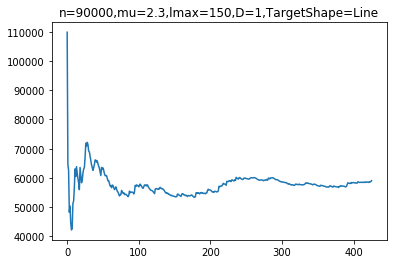

In [13]:
#Enough runs?
def Enough(L):
    AvList=[]
    l=len(L); s=L[0]
    for i in range(l):
        s+=L[i]
        AvList.append(s/float(i+1))
    plt.plot(AvList)

#n=300**2
#lmax=150
#TargetShape='Ball'
Enough(TimesLevyProbaDetect[(n,mu,lmax,D,TargetShape,p)])
plt.title('n=%s,mu=%s,lmax=%s,D=%s,TargetShape=%s' %(n,mu,lmax,D,TargetShape))
    #Compute Average List

In [ ]:
###SAVE

In [9]:
filehandler=open('HittingTimeLevyDifferentSizeTargetShapeCutOffProbaDetect.obj','w')
pickle.dump(TimesLevyProbaDetect,filehandler)
filehandler.close()